In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopy.distance
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")

# Orders

In [2]:
orders = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")

In [3]:
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

In [4]:
orders.shape

(99441, 8)

In [5]:
orders["order_id"].nunique()

99441

In [19]:
# Calculate predicted and actual duplicates
print("Predicted duplicates =", orders.shape[0] - orders["order_id"].nunique())
print("Actual duplicates =", orders.duplicated(subset = ["order_id"]).sum())

Predicted duplicates = 0
Actual duplicates = 0


In [4]:
# Preprocessing V1

# Convert all datetime cols from string type to datetime type
datetime_cols = ['order_approved_at', 'order_delivered_carrier_date', 'order_purchase_timestamp',
                 'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in datetime_cols:
    orders[col] = pd.to_datetime(orders[col])

# Feature Engineering

# Make a feature that measures the approval duration from purchase time
orders["approval_duration"] = orders["order_approved_at"] - orders["order_purchase_timestamp"]
orders["approval_duration"] = orders["approval_duration"].apply(lambda x: x.total_seconds())

# Make a feature that calculates estimated shipping duration
orders["estimated_duration"] = orders["order_delivered_customer_date"] - orders["order_delivered_carrier_date"]
orders["estimated_duration"] = orders["estimated_duration"].apply(lambda x: x.days)

# Make a feature that calculates actual shiping duration
orders["actual_duration"] = orders["order_estimated_delivery_date"] - orders["order_delivered_carrier_date"]
orders["actual_duration"] = orders["actual_duration"].apply(lambda x: x.days)

# Make a feature to flag if the delivery is late or not
orders["is_late"] = (orders["estimated_duration"] - orders["actual_duration"]).apply(lambda x: 1 if x < 0 else 0)

# Preprocessing V2

# Handle missing values in duration by filling with zero
orders["approval_duration"] = orders["approval_duration"].fillna(0)
orders["estimated_duration"] = orders["estimated_duration"].fillna(0)
orders["actual_duration"] = orders["actual_duration"].fillna(0)

# Filter out outliers that is instances with negative estimated or actual duration
orders = orders.query("estimated_duration > 0").reset_index(drop = True)
orders = orders.query("actual_duration > 0").reset_index(drop = True)

# Filter out outliers that which we can tune
orders = orders.query("estimated_duration <= 50").reset_index(drop = True)
orders = orders.query("actual_duration <= 50").reset_index(drop = True)

In [5]:
# Get the number of unique orders done by each customer
orders.groupby("customer_id")["order_id"].count().sort_values(ascending = False).reset_index()

customer_id  order_id
0      00012a2ce6f8dcda20d059ce98491703         1
1      aa743174847b78266e47461b8bcd1bb5         1
2      aa7210736aad65a84e964cfa8d64aa66         1
3      aa72002446dfbac0691304465c1b982d         1
4      aa71b21388b99444414a772acde9f6aa         1
...                                 ...       ...
92420  55883315bfdf93b29586555bf619e117         1
92421  55882cb9d69cdca67b5b9d29ac15ff1f         1
92422  5587073a673239e340006c2ee9e215d2         1
92423  5586f979cd49ae9f5a78c57f6eccd8cd         1
92424  ffffa3172527f765de70084a7e53aae8         1

[92425 rows x 2 columns]

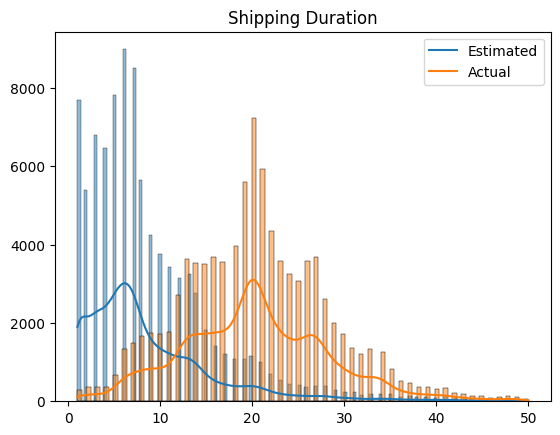

In [266]:
# Visualize estimated and actual distribution
sns.histplot(orders["estimated_duration"], kde = True)
sns.histplot(orders["actual_duration"], kde = True)
plt.title("Shipping Duration")
plt.xlabel("")
plt.ylabel("")
plt.legend(["Estimated", "Actual"])
plt.show()

In [267]:
# Visualize relationship between estimated and actual duration
fig = px.density_heatmap(orders, x = "estimated_duration", y = "actual_duration", marginal_x = "histogram", marginal_y = "histogram")
fig.show()

In [260]:
# Visualize total number of sales made each day
order_counts = orders.groupby(orders["order_approved_at"].dt.date)["order_id"].count().reset_index()
fig = px.line(order_counts, x = "order_approved_at", y = "order_id", title = "Total Sales")
fig.show()

In [34]:
# Visualize total number of sales made each day
order_counts = orders.groupby([orders["order_approved_at"].dt.date, orders["order_status"]])["order_id"].count().reset_index()
order_counts = pd.pivot_table(order_counts, index = "order_approved_at", columns = "order_status", values = "order_id").fillna(0)

order_counts["total"] = order_counts.sum(axis = 1)
order_counts["approved_ratio"] = order_counts["approved"]/order_counts["total"]
order_counts["canceled_ratio"] = order_counts["canceled"]/order_counts["total"]
order_counts["delivered_ratio"] = order_counts["delivered"]/order_counts["total"]
order_counts["invoiced_ratio"] = order_counts["invoiced"]/order_counts["total"]
order_counts["processing_ratio"] = order_counts["processing"]/order_counts["total"]
order_counts["shipped_ratio"] = order_counts["shipped"]/order_counts["total"]
order_counts["unavailable_ratio"] = order_counts["unavailable"]/order_counts["total"]

order_counts.drop(["approved", "canceled", "delivered", "invoiced", "processing", "shipped", "unavailable"], axis = 1, inplace = True)

fig = px.line(order_counts, x = order_counts.index, y = order_counts.columns, title = "Total Sales Ratio by Order Status")
fig.show()

In [220]:
# Visualize the day by day approval duration
order_durations = orders.groupby(orders["order_approved_at"].dt.date)["approval_duration"].mean().reset_index()
fig = px.line(order_durations, x = "order_approved_at", y = "approval_duration", title = "Approval Duration")
fig.show()

In [126]:
# Visualize order status distribution
order_counts = orders["order_status"].value_counts().reset_index()
fig = px.pie(order_counts, values = "count", names = "order_status")
fig.show()

In [128]:
# Visualize order status distribution
order_counts = orders["order_status"].value_counts().reset_index()
fig = go.Figure(data = [go.Pie(labels = order_counts["order_status"], values = order_counts["count"], hole = .3)])
fig.show()

In [191]:
# Visualize how many late delivered orders are there
delivered_orders = orders.query("order_status == 'delivered'").reset_index(drop = True)
late_counts = delivered_orders["is_late"].value_counts().reset_index()
fig = px.pie(late_counts, values = "count", names = "is_late", title = "Is the order late?")
fig.show()

In [325]:
# Visualize the proportion of late orders from day by day
late_orders = orders.groupby([orders["order_delivered_carrier_date"].dt.date]).agg({"is_late":"sum", "order_id":"count"})
late_orders["late_ratio"] = late_orders["is_late"]/late_orders["order_id"]
fig = px.line(late_orders, x = late_orders.index, y = "late_ratio", title = "Proportion of Late Orders")
fig.show()

# Order Items

In [7]:
order_items = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")

In [8]:
order_items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [271]:
order_items.shape

(112650, 7)

In [273]:
order_items["order_id"].nunique()

98666

In [9]:
# Convert date from string to datetime
order_items["shipping_limit_date"] = pd.to_datetime(order_items["shipping_limit_date"])

# Make a feature that gets the total price
order_items["total_price"] = order_items["price"] + order_items["freight_value"]

In [43]:
# Get the number of products bought distribution per order id
order_items["order_item_id"].value_counts().reset_index().rename(columns = {"order_item_id":"frequency"})

frequency  count
0           1  98666
1           2   9803
2           3   2287
3           4    965
4           5    460
5           6    256
6           7     58
7           8     36
8           9     28
9          10     25
10         11     17
11         12     13
12         13      8
13         14      7
14         15      5
15         16      3
16         17      3
17         18      3
18         19      3
19         20      3
20         21      1

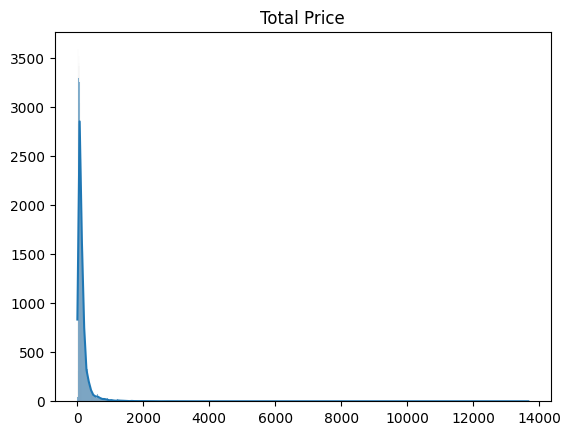

In [304]:
# Visualize total price distribution
sns.histplot(order_items.groupby("order_id")["total_price"].sum().reset_index(drop = True), kde = True)
plt.title("Total Price")
plt.xlabel("")
plt.ylabel("")
plt.show()

In [314]:
# Visualize number of shipments per day
order_counts = order_items.groupby(order_items["shipping_limit_date"].dt.date)["order_id"].count().reset_index()
fig = px.line(order_counts, x = "shipping_limit_date", y = "order_id", title = "Number of Shipments")
fig.show()

In [53]:
# Calculate predicted and actual duplicates
print("Predicted duplicates =", order_items.shape[0] - order_items["order_id"].nunique())
print("Actual duplicates =", order_items.duplicated(subset = ["order_id"]).sum())

Predicted duplicates = 13984
Actual duplicates = 13984


In [10]:
# Merge orders and order items dataframe
merged_1 =  pd.merge(order_items, orders, how = "left", on = "order_id")

In [63]:
# Visualize total revenue each day
order_revenues = merged_1.groupby(merged_1["order_delivered_carrier_date"].dt.date)["total_price"].sum().reset_index()
fig = px.line(order_revenues, x = "order_delivered_carrier_date", y = "total_price", title = "Total Revenue")
fig.show()

In [72]:
# Visualize cumulative revenue obtained each day
cumulative_revenues = order_revenues["total_price"].cumsum().reset_index()
cumulative_revenues.drop("index", axis = 1, inplace = True)
cumulative_revenues["order_delivered_carrier_date"] = order_revenues["order_delivered_carrier_date"]
fig = px.line(cumulative_revenues, x = "order_delivered_carrier_date", y = "total_price", title = "Cumulative Revenue")
fig.show()

# Order Payments and Reviews

In [338]:
order_payments = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")

In [339]:
order_payments.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

In [328]:
order_payments.shape

(103886, 5)

In [329]:
order_payments["order_id"].nunique()

99440

In [334]:
# Get the number of sequential payments needed for each order
order_payments["payment_sequential"].value_counts().reset_index().rename(columns = {"payment_sequential":"frequency"})

frequency  count
0           1  99360
1           2   3039
2           3    581
3           4    278
4           5    170
5           6    118
6           7     82
7           8     54
8           9     43
9          10     34
10         11     29
11         12     21
12         13     13
13         14     10
14         15      8
15         18      6
16         19      6
17         16      6
18         17      6
19         21      4
20         20      4
21         22      3
22         26      2
23         24      2
24         23      2
25         25      2
26         29      1
27         28      1
28         27      1

In [340]:
# Visualize order status distribution
payments = order_payments["payment_type"].value_counts().reset_index()
fig = go.Figure(data = [go.Pie(labels = payments["payment_type"], values = payments["count"], hole = .3)])
fig.show()

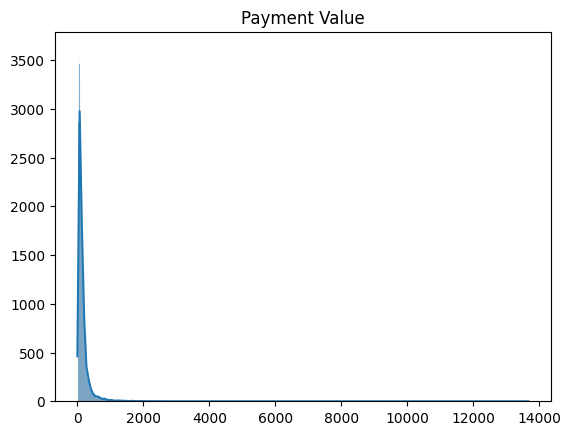

In [343]:
# Visualize payment value distribution
sns.histplot(order_payments.groupby("order_id")["payment_value"].sum().reset_index(drop = True), kde = True)
plt.title("Payment Value")
plt.xlabel("")
plt.ylabel("")
plt.show()

In [10]:
order_reviews = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")

In [11]:
order_reviews.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

# Geolocation, Customers, and Sellers

In [11]:
geos = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv")
customers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")
sellers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")

In [396]:
geos.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

In [397]:
geos.shape

(1000163, 5)

In [398]:
geos["geolocation_zip_code_prefix"].nunique()

19015

In [12]:
geos = geos.groupby("geolocation_zip_code_prefix").agg({"geolocation_lat":"mean", "geolocation_lng":"mean"}).reset_index()

In [13]:
geos.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                         1001       -23.550190       -46.634024
1                         1002       -23.548146       -46.634979
2                         1003       -23.548994       -46.635731
3                         1004       -23.549799       -46.634757
4                         1005       -23.549456       -46.636733

In [401]:
customers.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [402]:
customers.shape

(99441, 5)

In [14]:
customers = pd.merge(customers, geos.rename(columns = {"geolocation_zip_code_prefix":"customer_zip_code_prefix", 
                                         "geolocation_lat":"customer_geolocation_lat", 
                                         "geolocation_lng":"customer_geolocation_lng"}), 
                     how = "left", on = "customer_zip_code_prefix")

In [15]:
customers.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

   customer_geolocation_lat  customer_geolocation_lng  
0                -20.498489                -47.396929  
1                -23.727992                -46.542848  
2                -23.531642                -46.656289  
3                -23.499702                -46.185233  
4                -22.975100                -47.142925

In [16]:
sellers.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

In [407]:
sellers.shape

(3095, 4)

In [17]:
sellers = pd.merge(sellers, geos.rename(columns = {"geolocation_zip_code_prefix":"seller_zip_code_prefix", 
                                         "geolocation_lat":"seller_geolocation_lat", 
                                         "geolocation_lng":"seller_geolocation_lng"}), 
                   how = "left", on = "seller_zip_code_prefix")

In [18]:
sellers.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  seller_geolocation_lat  \
0           campinas           SP              -22.893848   
1         mogi guacu           SP              -22.383437   
2     rio de janeiro           RJ              -22.909572   
3          sao paulo           SP              -23.657242   
4  braganca paulista           SP              -22.964803   

   seller_geolocation_lng  
0              -47.061337  
1              -46.947927  
2              -43.177703  
3              -46.612831  
4              -46.534419

In [19]:
# Merge sellers and customers dataframe with orders and order items
merged_2 = pd.merge(merged_1, sellers, how = "left", on = "seller_id")
merged_3 = pd.merge(merged_2, customers, how = "left", on = "customer_id")

In [430]:
# Get the destination counts for each seller-customer combination
combinations = merged_3.groupby("seller_city")["customer_city"].value_counts().reset_index()
combinations = pd.pivot_table(combinations, index = "seller_city", columns = "customer_city", values = "count").fillna(0)
combinations["total"] = combinations.sum(axis = 1)
combinations.sort_values(by = "total", ascending = False)

customer_city              abadia dos dourados  abadiania  abaete  abaetetuba  \
seller_city                                                                     
sao paulo                                  1.0        1.0     3.0         3.0   
ibitinga                                   0.0        0.0     1.0         0.0   
curitiba                                   0.0        0.0     0.0         0.0   
santo andre                                0.0        0.0     0.0         0.0   
sao jose do rio preto                      0.0        0.0     0.0         1.0   
...                                        ...        ...     ...         ...   
tocantins                                  0.0        0.0     0.0         0.0   
resende                                    0.0        0.0     0.0         0.0   
goioere                                    0.0        0.0     0.0         0.0   
sao sebastiao da grama/sp                  0.0        0.0     0.0         0.0   
abadia de goias                            0.0        0.0     0.0         0.0   

customer_city              abaiara  abaira  abare  abatia  abdon batista  \
seller_city                                                                
sao paulo                      0.0     2.0    1.0     1.0            0.0   
ibitinga                       0.0     0.0    0.0     1.0            2.0   
curitiba                       0.0     0.0    0.0     0.0            0.0   
santo andre                    0.0     0.0    0.0     0.0            0.0   
sao jose do rio preto          0.0     0.0    0.0     0.0            0.0   
...                            ...     ...    ...     ...            ...   
tocantins                      0.0     0.0    0.0     0.0            0.0   
resende                        0.0     0.0    0.0     0.0            0.0   
goioere                        0.0     0.0    0.0     0.0            0.0   
sao sebastiao da grama/sp      0.0     0.0    0.0     0.0            0.0   
abadia de goias                0.0     0.0    0.0     0.0            0.0   

customer_city              abelardo luz  ...  xapuri  xavantina  xaxim  xexeu  \
seller_city                              ...                                    
sao paulo                           1.0  ...     0.0        1.0    4.0    1.0   
ibitinga                            0.0  ...     0.0        0.0    0.0    0.0   
curitiba                            1.0  ...     0.0        0.0    1.0    0.0   
santo andre                         0.0  ...     0.0        0.0    1.0    0.0   
sao jose do rio preto               1.0  ...     0.0        0.0    0.0    0.0   
...                                 ...  ...     ...        ...    ...    ...   
tocantins                           0.0  ...     0.0        0.0    0.0    0.0   
resende                             0.0  ...     0.0        0.0    0.0    0.0   
goioere                             0.0  ...     0.0        0.0    0.0    0.0   
sao sebastiao da grama/sp           0.0  ...     0.0        0.0    0.0    0.0   
abadia de goias                     0.0  ...     0.0        0.0    0.0    0.0   

customer_city              xinguara  xique-xique  zacarias  ze doca  zortea  \
seller_city                                                                   
sao paulo                       1.0          0.0       0.0      2.0     1.0   
ibitinga                        0.0          1.0       0.0      0.0     0.0   
curitiba                        0.0          0.0       0.0      0.0     0.0   
santo andre                     0.0          0.0       0.0      0.0     0.0   
sao jose do rio preto           0.0          0.0       0.0      0.0     0.0   
...                             ...          ...       ...      ...     ...   
tocantins                       0.0          0.0       0.0      0.0     0.0   
resende                         0.0          0.0       0.0      0.0     0.0   
goioere                         0.0          0.0       0.0      0.0     0.0   
sao sebastiao da grama/sp       0.

In [435]:
# Check for fare distribution and its corresponding booking value
dummy = merged_3.groupby(["customer_geolocation_lat", "customer_geolocation_lng"])["order_id"].count().reset_index()
dummy["Total Value"] = merged_3.groupby(["customer_geolocation_lat", "customer_geolocation_lng"])["total_price"].mean().reset_index(drop = True)
fig = px.scatter_map(dummy, lat = "customer_geolocation_lat", lon = "customer_geolocation_lng", color = "Total Value", size = "order_id",
                  color_continuous_scale = px.colors.cyclical.IceFire, size_max = 15, zoom = 10,
                  map_style = "carto-positron")
fig.show()

In [20]:
# Handle missing values by dropping instances
merged_3.dropna(subset = ["seller_geolocation_lat", "seller_geolocation_lng", 
                         "customer_geolocation_lat", "customer_geolocation_lng"], inplace = True)

# Reset index after dropping values
merged_3.reset_index(drop = True, inplace = True)

In [21]:
# Calculate distances between seller and customer location
distances = []
for i in range(len(merged_3)):
    coords_1 = (merged_3.loc[i, "seller_geolocation_lat"], merged_3.loc[i, "seller_geolocation_lng"])
    coords_2 = (merged_3.loc[i, "customer_geolocation_lat"], merged_3.loc[i, "customer_geolocation_lng"])
    distances.append(geopy.distance.geodesic(coords_1, coords_2).km)
merged_3["distance"] = distances

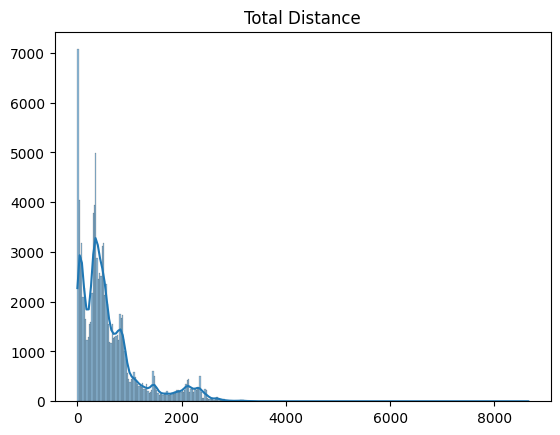

In [22]:
# Visualize distance distribution
sns.histplot(merged_3["distance"], kde = True)
plt.title("Total Distance")
plt.xlabel("")
plt.ylabel("")
plt.show()

In [23]:
# Visualize relationship between travel distance and freight value
fig = px.scatter(merged_3, x = "distance", y = "freight_value")
fig.show()

# Products and Category

In [24]:
products = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
category = pd.read_csv("/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv")

In [25]:
products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [26]:
products.shape

(32951, 9)

In [27]:
products["product_category_name"].nunique()

73

In [28]:
category.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

In [29]:
category.shape

(71, 2)

In [30]:
category["product_category_name"].nunique()

71

In [31]:
category

product_category_name product_category_name_english
0                    beleza_saude                 health_beauty
1          informatica_acessorios         computers_accessories
2                      automotivo                          auto
3                 cama_mesa_banho                bed_bath_table
4                moveis_decoracao               furniture_decor
..                            ...                           ...
66                         flores                       flowers
67             artes_e_artesanato         arts_and_craftmanship
68                fraldas_higiene           diapers_and_hygiene
69  fashion_roupa_infanto_juvenil     fashion_childrens_clothes
70             seguros_e_servicos         security_and_services

[71 rows x 2 columns]

In [32]:
# Merge product and category into one unified dataframe
merged_4 = pd.merge(products, category, on = "product_category_name", how = "left")

In [33]:
# Visualize number of unique products in each category
category_counts = merged_4.groupby("product_category_name_english")["product_id"].count().sort_values(ascending = False).reset_index()
fig = px.bar(category_counts, x = "product_category_name_english", y = "product_id", title = "Product Category")
fig.show()

In [37]:
# Merge product category dataframe with orders dataframe
merged_5 = pd.merge(merged_3, merged_4, how = "left", on = "product_id")

In [44]:
# Get product categories with the highest demand
product_counts = merged_5.groupby("product_category_name_english")["order_id"].count().sort_values(ascending = False).reset_index()
fig = px.bar(product_counts, x = "product_category_name_english", y = "order_id", title = "Most Popular Product Categories")
fig.show()

In [46]:
# Get product category with the highest revenue
product_revenues = merged_5.groupby("product_category_name_english")["price"].mean().sort_values(ascending = False).reset_index()
fig = px.bar(product_revenues, x = "product_category_name_english", y = "price", title = "Highest Revenue Product Categories")
fig.show()

In [59]:
# Visualize each product category demand from time to time
product_counts = merged_5.groupby([merged_5["order_approved_at"].dt.date])["product_category_name_english"].value_counts().reset_index()
product_counts = pd.pivot_table(product_counts, index = "order_approved_at", columns = "product_category_name_english", values = "count").fillna(0)
product_counts["total"] = product_counts.sum(axis = 1)                                       
fig = px.line(product_counts, x = product_counts.index, y = product_counts.columns, title = "Total Sales by Product Category")
fig.show()

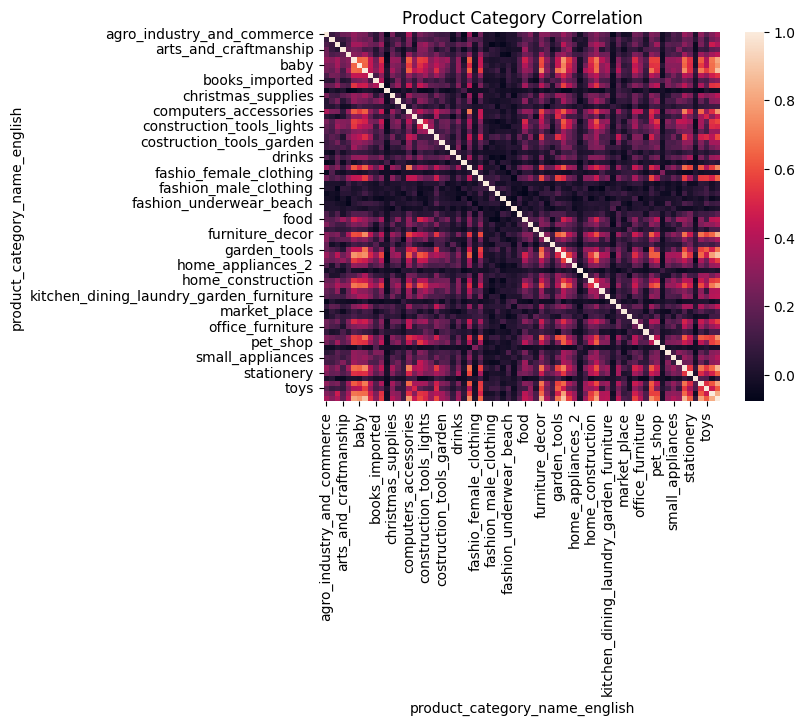

In [81]:
# Visualize how does the trend of one product relates to the other
sns.heatmap(product_counts.corr())
plt.title("Product Category Correlation")
plt.show()

In [83]:
# Make a feature to calculate shipment volume
merged_5["product_volume_cm3"] = merged_5["product_length_cm"] * merged_5["product_width_cm"] * merged_5["product_height_cm"]

In [85]:
# Visualize relationship between product volume and freight value
fig = px.scatter(merged_5, x = "product_volume_cm3", y = "freight_value")
fig.show()

In [86]:
# Visualize relationship between product weight and freight value
fig = px.scatter(merged_5, x = "product_weight_g", y = "freight_value")
fig.show()

In [98]:
# Visualize each product category distribution across customer city
product_counts = merged_5.groupby("customer_city")["product_category_name_english"].value_counts().reset_index()
product_counts = pd.pivot_table(product_counts, index = "customer_city", columns = "product_category_name_english", values = "count").fillna(0)
product_counts["total"] = product_counts.sum(axis = 1)
product_counts.sort_values(by = "total", ascending = False)

product_category_name_english  agro_industry_and_commerce  air_conditioning  \
customer_city                                                                 
sao paulo                                            41.0              34.0   
rio de janeiro                                       19.0              39.0   
belo horizonte                                        4.0               3.0   
brasilia                                              0.0               3.0   
curitiba                                              3.0               1.0   
...                                                   ...               ...   
maiquinique                                           0.0               0.0   
magalhaes de almeida                                  0.0               0.0   
mae d'agua                                            0.0               0.0   
madalena                                              0.0               0.0   
zortea                                                0.0               0.0   

product_category_name_english   art  arts_and_craftmanship  audio   auto  \
customer_city                                                              
sao paulo                      22.0                    1.0   57.0  481.0   
rio de janeiro                 16.0                    0.0   31.0  191.0   
belo horizonte                  6.0                    1.0   10.0  101.0   
brasilia                        6.0                    1.0   15.0  102.0   
curitiba                        2.0                    0.0   10.0   52.0   
...                             ...                    ...    ...    ...   
maiquinique                     0.0                    0.0    0.0    0.0   
magalhaes de almeida            0.0                    0.0    0.0    0.0   
mae d'agua                      0.0                    0.0    0.0    0.0   
madalena                        0.0                    0.0    0.0    0.0   
zortea                          0.0                    0.0    0.0    0.0   

product_category_name_english   baby  bed_bath_table  books_general_interest  \
customer_city                                                                  
sao paulo                      422.0          1827.0                    63.0   
rio de janeiro                 157.0           814.0                    24.0   
belo horizonte                  96.0           340.0                    11.0   
brasilia                        63.0           189.0                    16.0   
curitiba                        45.0           135.0                     4.0   
...                              ...             ...                     ...   
maiquinique                      1.0             0.0                     0.0   
magalhaes de almeida             0.0             0.0                     0.0   
mae d'agua                       0.0             0.0                     0.0   
madalena                         0.0             0.0                     0.0   
zortea                           0.0             0.0                     0.0   

product_category_name_english  books_imported  ...  signaling_and_security  \
customer_city                                  ...                           
sao paulo                                15.0  ...                    39.0   
rio de janeiro                            2.0  ...                    12.0   
belo horizonte                            1.0  ...                     6.0   
brasilia                                  0.0  ...                     2.0   
curitiba                                  0.0  ...                     2.0   
...                                       ...  ...                     ...   
maiquinique                               0.0  ...                     0.0   
magalhaes de almeida                      0.0  ...                     0.0   
mae d'agua                                0.0  ...                     0.0   
madalena                                  0.0  ...                     0.0   
zortea